In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Montagem da Spark Session com carregamento do arquivo CSV pelo Spark

spark = SparkSession.builder.appName("video-game-sales").getOrCreate()
csv_file_path = "/content/drive/MyDrive/vgsales.csv"
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

In [ ]:
# Tratamento de dados removendo linhas sem ano ou publisher definidos
df = df.filter((df.Year != 'N/A') & (df.Publisher != 'Unknown'))

In [ ]:
df.show()

+----+--------------------+--------+----+------------+--------------------+--------+--------+--------+-----------+------------+
|Rank|                Name|Platform|Year|       Genre|           Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|
+----+--------------------+--------+----+------------+--------------------+--------+--------+--------+-----------+------------+
|   1|          Wii Sports|     Wii|2006|      Sports|            Nintendo|   41.49|   29.02|    3.77|       8.46|       82.74|
|   2|   Super Mario Bros.|     NES|1985|    Platform|            Nintendo|   29.08|    3.58|    6.81|       0.77|       40.24|
|   3|      Mario Kart Wii|     Wii|2008|      Racing|            Nintendo|   15.85|   12.88|    3.79|       3.31|       35.82|
|   4|   Wii Sports Resort|     Wii|2009|      Sports|            Nintendo|   15.75|   11.01|    3.28|       2.96|        33.0|
|   5|Pokemon Red/Pokem...|      GB|1996|Role-Playing|            Nintendo|   11.27|    8.89|   10.22|  

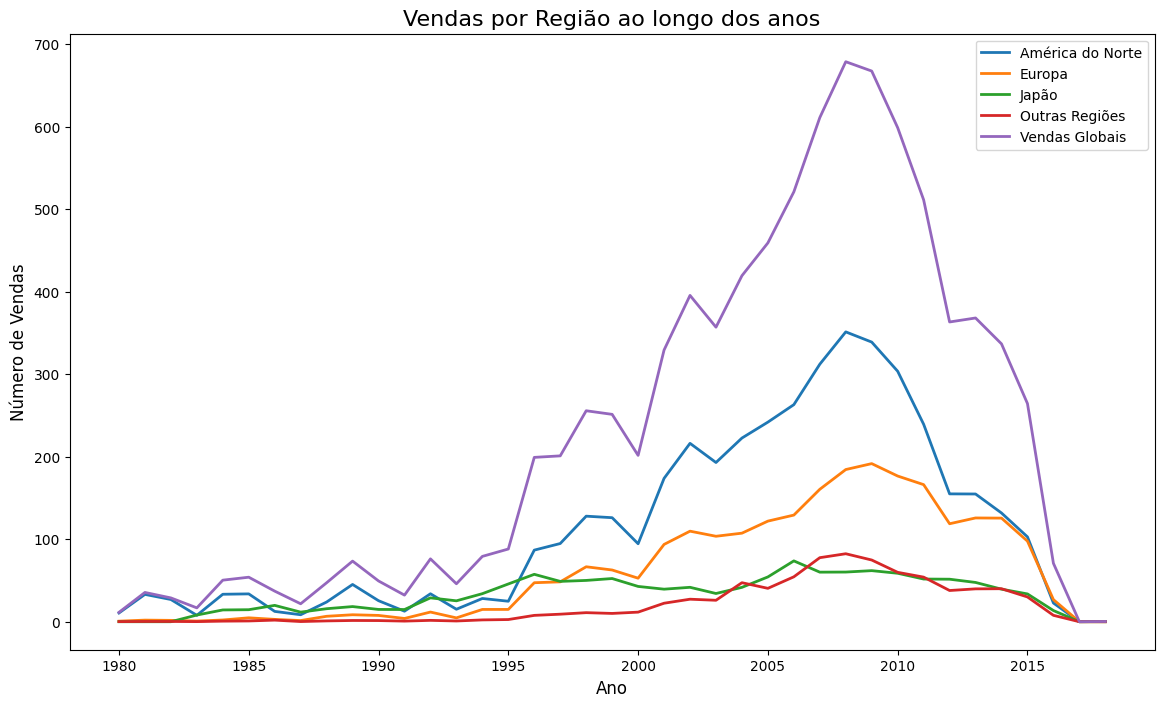

In [ ]:
pdf = df.toPandas()

# Criação de Aliases para as colunas

column_aliases = {
    'NA_Sales': 'América do Norte',
    'EU_Sales': 'Europa',
    'JP_Sales': 'Japão',
    'Other_Sales': 'Outras Regiões',
    'Global_Sales': 'Vendas Globais'
}

# Dataset incluindo apenas as colunas de região + a coluna de vendas

pdf_sales_by_region = pdf[[region for region in pdf.columns if "Sales" in region] + ["Year"]]
pdf_sales_by_region = pdf_sales_by_region.rename(columns=column_aliases)

fig_sales_by_region = plt.figure(figsize=(14, 8))

pdf_sales_by_region.groupby("Year").sum().plot(kind='line', ax=plt.gca(), linewidth=2)

plt.title('Vendas por Região ao longo dos anos', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Número de Vendas', fontsize=12)

plt.show()


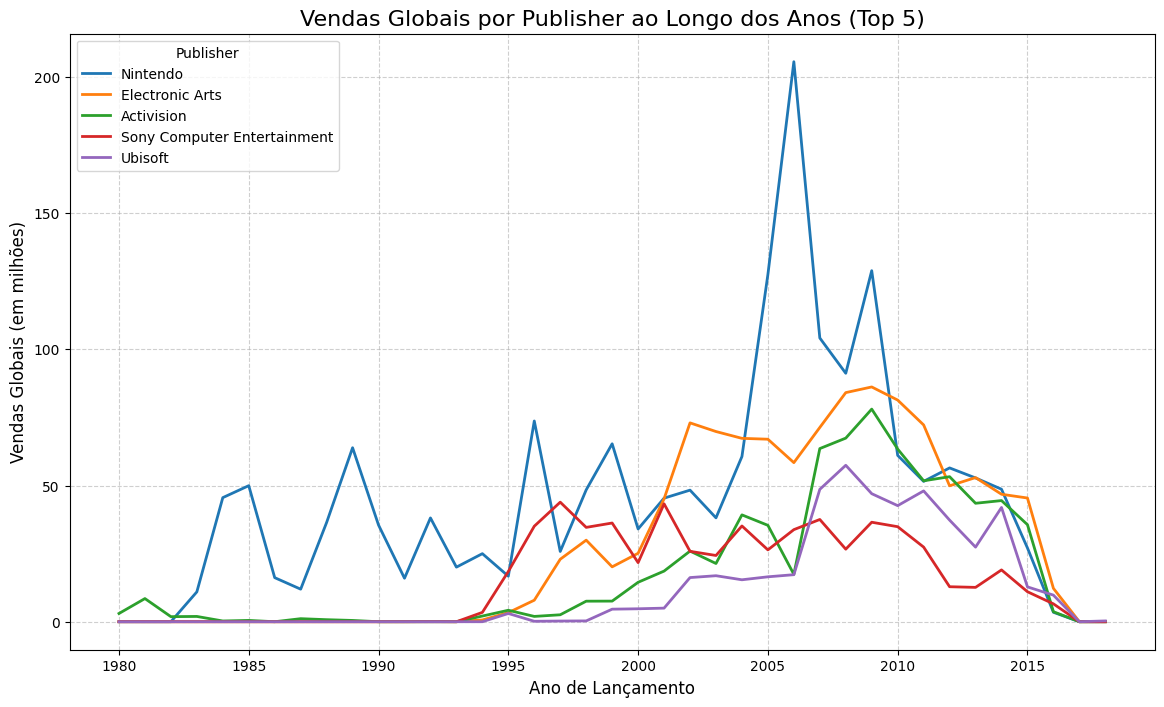

In [ ]:
# Agrupando dataset pelas colunas 'Publisher' e 'Year', fazendo a soma das vendas globais

sales_by_publisher_year = pdf.groupby(['Publisher', 'Year'])['Global_Sales'].sum().reset_index()
sales_pivot = sales_by_publisher_year.pivot(index='Year', columns='Publisher', values='Global_Sales').fillna(0)

# Selecionando somente as 5 publishers com mais vendas, pela alta quantidade de publishers presentes no dataset

top_publishers = pdf.groupby('Publisher')['Global_Sales'].sum().nlargest(5).index
sales_to_plot = sales_pivot[top_publishers]

fig_top_publishers = plt.figure(figsize=(14, 8))
sales_to_plot.plot(kind='line', ax=plt.gca(), linewidth=2)

plt.title('Vendas Globais por Publisher ao Longo dos Anos (Top 5)', fontsize=16)
plt.xlabel('Ano de Lançamento', fontsize=12)
plt.ylabel('Vendas Globais (em milhões)', fontsize=12)

plt.legend(title='Publisher', loc='upper left')

plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

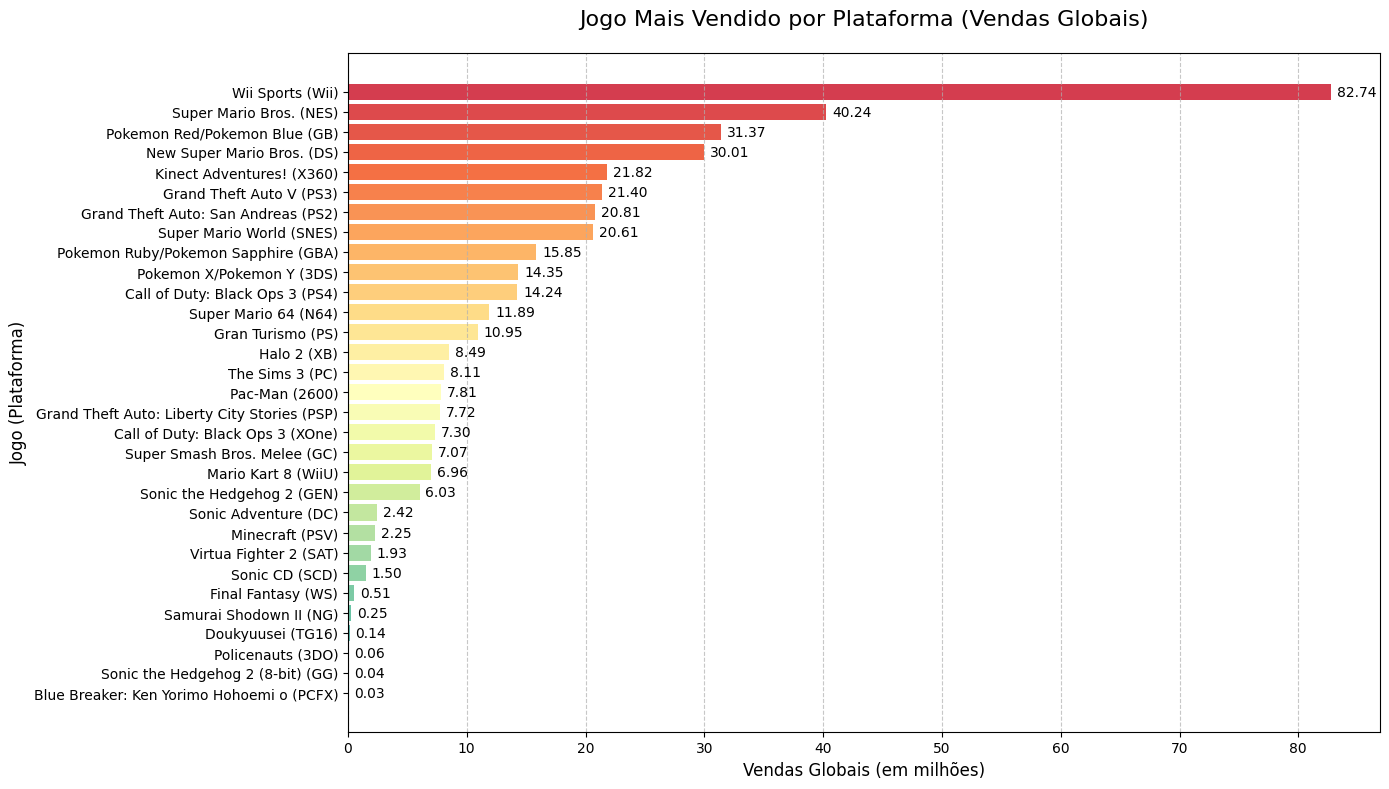

In [ ]:
# Agrupamento pelas colunas 'Platform', selecionando o número de índice do jogo mais vendido

idx_max_sales = pdf.groupby('Platform')['Global_Sales'].idxmax()

top_game_per_platform = pdf.loc[idx_max_sales]

top_game_per_platform = top_game_per_platform.sort_values(by='Global_Sales', ascending=False)

# Criação da coluna 'Game_Label' no dataset, que é a junção do nome + plataforma.

top_game_per_platform['Game_Label'] = top_game_per_platform['Name'] + ' (' + top_game_per_platform['Platform'] + ')'

games = top_game_per_platform['Game_Label']
sales = top_game_per_platform['Global_Sales']

fig_top_game_per_platform, ax = plt.subplots(figsize=(14, 8))

bars = ax.barh(games, sales, color=plt.cm.Spectral(np.linspace(0.1, 0.9, len(games))))

ax.set_title('Jogo Mais Vendido por Plataforma (Vendas Globais)', fontsize=16, pad=20)
ax.set_xlabel('Vendas Globais (em milhões)', fontsize=12)
ax.set_ylabel('Jogo (Plataforma)', fontsize=12)

for bar in bars:
    ax.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height()/2,
        f'{bar.get_width():.2f}',
        va='center',
        ha='left',
        fontsize=10,
        color='black'
    )

ax.invert_yaxis()

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

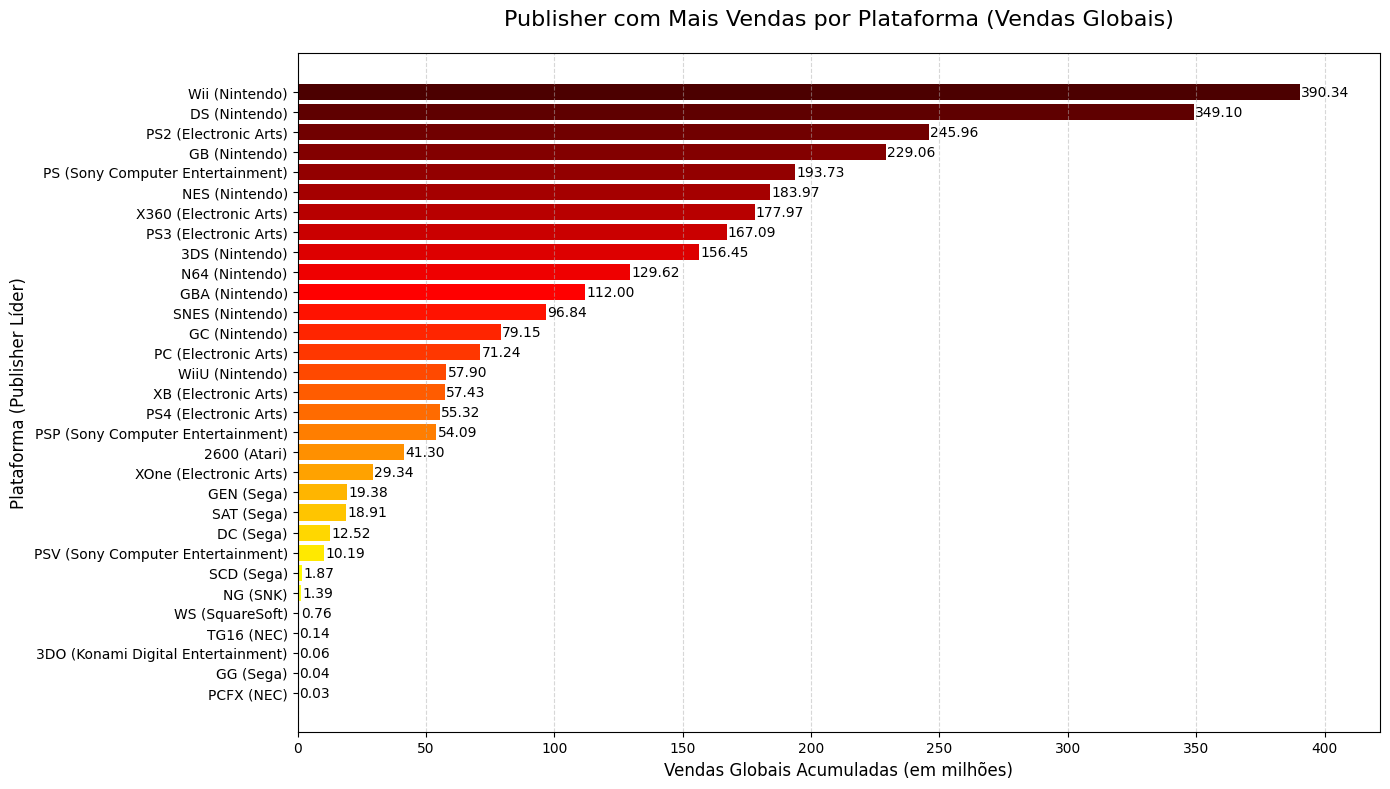

In [ ]:
# Agrupamento da coluna 'Platform' e 'Publisher', fazendo a soma de 'Global_Sales'.

platform_publisher_sales = pdf.groupby(['Platform', 'Publisher'])['Global_Sales'].sum().reset_index()

idx_max_publisher = platform_publisher_sales.groupby('Platform')['Global_Sales'].idxmax()

top_publisher_per_platform = platform_publisher_sales.loc[idx_max_publisher]

top_publisher_per_platform = top_publisher_per_platform.sort_values(by='Global_Sales', ascending=False)

top_publisher_per_platform['Label'] = top_publisher_per_platform['Platform'] + ' (' + top_publisher_per_platform['Publisher'] + ')'

labels = top_publisher_per_platform['Label']
sales = top_publisher_per_platform['Global_Sales']

fig_top_publisher_per_platform, ax = plt.subplots(figsize=(14, 8))

# Uso do colormap Spectral do matplotlib para criação do agrupamento de

colors = plt.cm.hot(np.linspace(0.1, 0.9, len(labels)))
bars = ax.barh(labels, sales, color=colors)

ax.set_title('Publisher com Mais Vendas por Plataforma (Vendas Globais)', fontsize=16, pad=20)
ax.set_xlabel('Vendas Globais Acumuladas (em milhões)', fontsize=12)
ax.set_ylabel('Plataforma (Publisher Líder)', fontsize=12)

for bar in bars:
    ax.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height()/2,
        f'{bar.get_width():.2f}',
        va='center',
        ha='left',
        fontsize=10,
        color='black'
    )

ax.invert_yaxis()

ax.set_xlim(right=sales.max() * 1.08)

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
!pip install -q streamlit
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
# import subprocess
# subprocess.Popen(["./cloudflared-linux-amd64", "tunnel", "--url", "http://localhost:8501"])
!nohup /content/cloudflared-linux-amd64 tunnel --url http://localhost:8501 &

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 117.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 109.3 MB/s eta 0:00:00
--2025-11-30 14:16:27--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64 [following]
--2025-11-30 14:16:27--  https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/955e9d1b-ac5e-4188-8867-e5f53958a8fe?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-30T15%3A07%3A56Z&rscd=attachment%3B+filename%

In [ ]:
!grep -o 'https://.*\.trycloudflare.com' nohup.out | head -n 1 | xargs -I {} echo "Your tunnel url {}"
# Clique no Link do tunel...

Your tunnel url https://foods-timeline-scripts-happiness.trycloudflare.com


In [ ]:
!streamlit run /content/app.py &>/content/logs.txt &

In [ ]:
!streamlit run app.py &>/content/logs.txt &

In [ ]:
%%writefile app.py
import streamlit as st
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

st.set_page_config(page_title='Video Game Dataset', page_icon='🎮', layout='wide', initial_sidebar_state='auto')

spark = SparkSession.builder.appName("video-game-sales").getOrCreate()
csv_file_path = "/content/drive/MyDrive/vgsales.csv"
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

df = df.filter((df.Year != 'N/A') & (df.Publisher != 'Unknown'))

pdf = df.toPandas()

## Gráfico 'Vendas por Região ao longo dos Anos'

column_aliases = {
    'NA_Sales': 'América do Norte',
    'EU_Sales': 'Europa',
    'JP_Sales': 'Japão',
    'Other_Sales': 'Outras Regiões',
    'Global_Sales': 'Vendas Globais'
}

pdf_sales_by_region = pdf[[region for region in pdf.columns if "Sales" in region] + ["Year"]]
pdf_sales_by_region = pdf_sales_by_region.rename(columns=column_aliases)

fig_sales_by_region = plt.figure(figsize=(14, 8))

pdf_sales_by_region.groupby("Year").sum().plot(kind='line', ax=plt.gca(), linewidth=2)

plt.title('Vendas por Região ao longo dos anos', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Número de Vendas', fontsize=12)

plt.show()

## Gráfico 'Vendas Globais por publisher (Top 5)

sales_by_publisher_year = pdf.groupby(['Publisher', 'Year'])['Global_Sales'].sum().reset_index()
sales_pivot = sales_by_publisher_year.pivot(index='Year', columns='Publisher', values='Global_Sales').fillna(0)

top_publishers = pdf.groupby('Publisher')['Global_Sales'].sum().nlargest(5).index
sales_to_plot = sales_pivot[top_publishers]

fig_top_publishers = plt.figure(figsize=(14, 8))
sales_to_plot.plot(kind='line', ax=plt.gca(), linewidth=2)

plt.title('Vendas Globais por Publisher ao Longo dos Anos (Top 5)', fontsize=16)
plt.xlabel('Ano de Lançamento', fontsize=12)
plt.ylabel('Vendas Globais (em milhões)', fontsize=12)

plt.legend(title='Publisher', loc='upper left')

plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

## Gráfico 'Jogos mais vendidos por Plataforma'

idx_max_sales = pdf.groupby('Platform')['Global_Sales'].idxmax()

top_game_per_platform = pdf.loc[idx_max_sales]

top_game_per_platform = top_game_per_platform.sort_values(by='Global_Sales', ascending=False)

top_game_per_platform['Game_Label'] = top_game_per_platform['Name'] + ' (' + top_game_per_platform['Platform'] + ')'

games = top_game_per_platform['Game_Label']
sales = top_game_per_platform['Global_Sales']

fig_top_game_per_platform, ax = plt.subplots(figsize=(14, 8))

bars = ax.barh(games, sales, color=plt.cm.Spectral(np.linspace(0.1, 0.9, len(games))))

ax.set_title('Jogo Mais Vendido por Plataforma (Vendas Globais)', fontsize=16, pad=20)
ax.set_xlabel('Vendas Globais (em milhões)', fontsize=12)
ax.set_ylabel('Jogo (Plataforma)', fontsize=12)

for bar in bars:
    ax.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height()/2,
        f'{bar.get_width():.2f}',
        va='center',
        ha='left',
        fontsize=10,
        color='black'
    )

ax.invert_yaxis()

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Gráfico 'Publisher com mais vendas'

platform_publisher_sales = pdf.groupby(['Platform', 'Publisher'])['Global_Sales'].sum().reset_index()

idx_max_publisher = platform_publisher_sales.groupby('Platform')['Global_Sales'].idxmax()

top_publisher_per_platform = platform_publisher_sales.loc[idx_max_publisher]

top_publisher_per_platform = top_publisher_per_platform.sort_values(by='Global_Sales', ascending=False)

top_publisher_per_platform['Label'] = top_publisher_per_platform['Platform'] + ' (' + top_publisher_per_platform['Publisher'] + ')'

labels = top_publisher_per_platform['Label']
sales = top_publisher_per_platform['Global_Sales']

fig_top_publisher_per_platform, ax = plt.subplots(figsize=(14, 8))

colors = plt.cm.hot(np.linspace(0.1, 0.9, len(labels)))
bars = ax.barh(labels, sales, color=colors)

ax.set_title('Publisher com Mais Vendas por Plataforma (Vendas Globais)', fontsize=16, pad=20)
ax.set_xlabel('Vendas Globais Acumuladas (em milhões)', fontsize=12)
ax.set_ylabel('Plataforma (Publisher Líder)', fontsize=12)

for bar in bars:
    ax.text(
        bar.get_width() + 0.5,
        bar.get_y() + bar.get_height()/2,
        f'{bar.get_width():.2f}',
        va='center',
        ha='left',
        fontsize=10,
        color='black'
    )

ax.invert_yaxis()

ax.set_xlim(right=sales.max() * 1.08)

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Config Streamlit Visualization

st.title("Video Game Dataset 🎮")
st.pyplot(fig_sales_by_region)
st.pyplot(fig_top_publishers)
st.pyplot(fig_top_game_per_platform)
st.pyplot(fig_top_publisher_per_platform)

Overwriting app.py
